In [1]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

In [2]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using LuxDeviceUtils: cpu_device, gpu_device
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

Precompiling PhasorNetworks
  ✓ PhasorNetworks
  1 dependency successfully precompiled in 10 seconds. 424 already precompiled.


In [3]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [4]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [5]:
# solver_args = Dict(:adaptive => false, :dt => 0.01)

In [6]:
# spk_args = SpikingArgs(t_window = 0.01, 
#                     threshold = 0.001,
#                     solver=Heun(), 
#                     solver_args = solver_args)

In [7]:
#global args for all tests
n_x = 101
n_y = 101
n_vsa = 1
epsilon = 0.10
repeats = 10
epsilon = 0.025


tspan = (0.0, repeats*1.0)
tbase = collect(tspan[1]:spk_args.solver_args[:dt]:tspan[2])

@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
    rng::Xoshiro = Xoshiro(42) ## global rng
end

Args

In [8]:
include("../test/network_tests.jl")

spiking_accuracy_test (generic function with 1 method)

In [9]:
function build_mlp(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDense(2 => 128), PhasorDense(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp (generic function with 1 method)

In [10]:
function build_mlp_f32(args)
    phasor_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), x -> x, PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, phasor_model)
    return phasor_model, ps, st
end

function build_spiking_mlp_f32(args, spk_args)
    spk_model = Chain(LayerNorm((2,)), x -> tanh_fast.(x), MakeSpiking(spk_args, repeats), PhasorDenseF32(2 => 128), PhasorDenseF32(128 => 2))
    ps, st = Lux.setup(args.rng, spk_model)
    return spk_model, ps, st
end

build_spiking_mlp_f32 (generic function with 1 method)

In [11]:
import .PhasorNetworks: v_bundle_project, neuron_constant, spike_current, bias_current, gaussian_kernel, is_active

In [12]:
args = Args()

Args(0.0003, 256, 10, false, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [13]:
train_loader, test_loader = getdata(args)
x, y = first(train_loader)

([0.4363590795046628 -0.020726939563912576 … -0.014802110970796872 -0.0019893102515646105; -0.17784306532747968 0.3038012525038328 … -0.07276908176492998 -0.005627426425963785], Bool[0 0 … 1 1; 1 1 … 0 0])

In [14]:
model, ps, st = build_mlp_f32(args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.09775257 -0.033171576; 0.020251632 0.0070170956; … ; 0.04797584 0.04434996; -0.002902955 0.14405486], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = (weight = Float32[-0.7682285 0.26694193 … 0.07480648 0.34993985; 0.15990366 -0.17788795 … -0.27716428 1.1225573], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [15]:
spk_model, _, _ = build_spiking_mlp_f32(args, spk_args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.09775257 -0.033171576; 0.020251632 0.0070170956; … ; 0.04797584 0.04434996; -0.002902955 0.14405486], bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_5 = (weight = Float32[-0.7682285 0.26694193 … 0.07480648 0.34993985; 0.15990366 -0.17788795 … -0.27716428 1.1225573], bias_real = Float32[1.0, 1.0], bias_imag = Float32[0.0, 0.0])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [16]:
y, _ = model(x, ps, st)

([-0.0019279659805481156 -0.03240955426094522 … -0.04047798561910448 -0.022848835911276753; -0.00396018678206813 0.011284628756278715 … -0.0020098326228306664 0.0010613369167577354], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [17]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [18]:
y_spk.train.offset

0.5

In [19]:
p_spk = train_to_phase(y_spk);

In [20]:
size(p_spk)

(10, 2, 256)

In [21]:
size(y)

(2, 256)

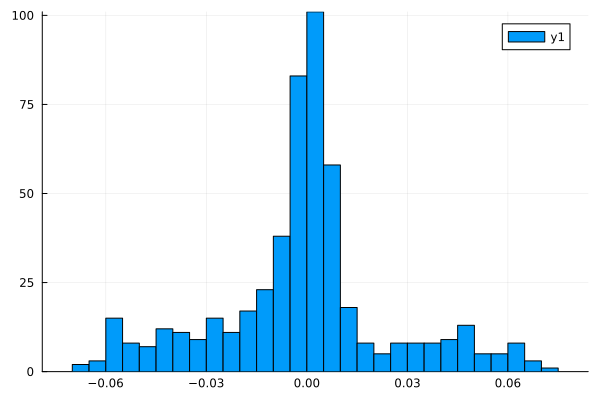

In [22]:
histogram(vec(p_spk[5,:,:]))

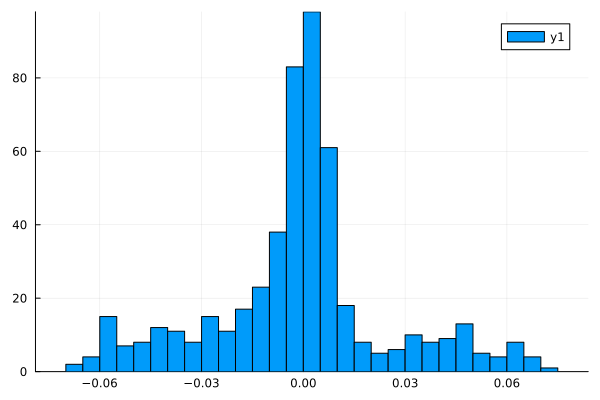

In [23]:
histogram(vec(p_spk[6,:,:]))

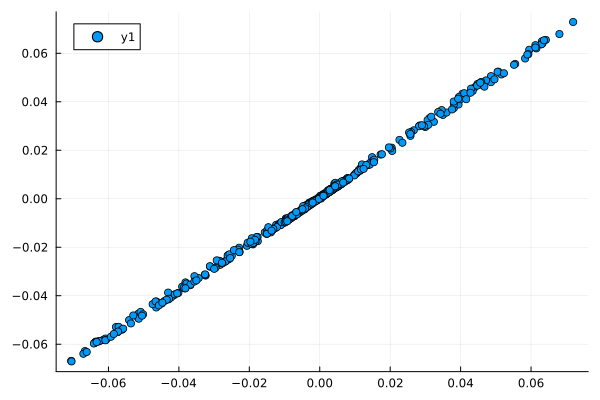

In [24]:
scatter(vec(y), vec(p_spk[5,:,:]))

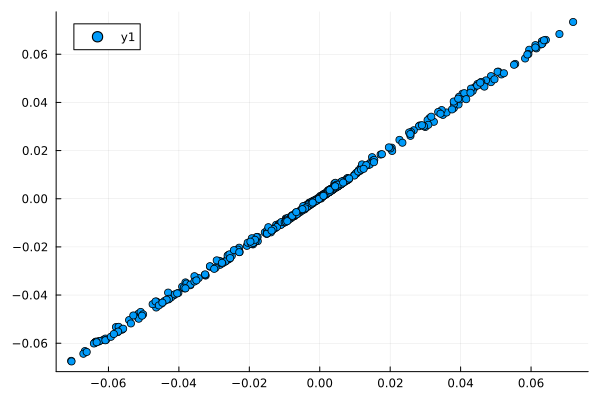

In [25]:
scatter(vec(y), vec(p_spk[6,:,:]))

In [26]:
y |> size

(2, 256)

In [27]:
p_spk |> size

(10, 2, 256)

In [28]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 NaN
   0.9993114918297449
   0.9993717809280009
   0.9993813874975087
   0.9993840329254258
   0.9993848942590626
   0.9993851570696396
   0.999385188220038
   0.9993851272233564
   0.9803989790111869

In [29]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[0.5098835524761419, 0.4853391464817246, 0.4914205969227063, 0.48693900762206077, 0.49542518873726243, 0.4933117083142159, 0.5004590997678297, 0.512756128327489, 0.4901452936831625, 0.5044134966952558  …  0.08985068676289487, 0.10115342521590981, 0.0875427628321754, 0.08865164641347476, 0.099460205970918, 0.09322154665346419, 0.09597347357738689, 0.09712121172911978, 0.1025847382860025, 0.08789165428169592], (layer_1 = (bias = Float32[0.2118337; 0.25200406;;], scale = Float32[0.79320455; 0.8671251;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.10259967 -0.056138404; 0.030605055 0.034390744; … ; 0.112613924 0.12548086; -0.013373454 0.13393202], bias_real = Float32[0.97534525, 0.98212874, 0.8002509, 1.0033823, 1.0261248, 0.92010224, 0.9399406, 1.0279227, 0.87734455, 0.99687  …  0.84923756, 0.86697584, 0.94516754, 0.98093194, 0.975632, 0.93395567, 0.98050535, 0.96922135, 0.90256816, 0.9452845], bias_imag = Float32[-0.022570381, -5.091935f-5, 0.1220

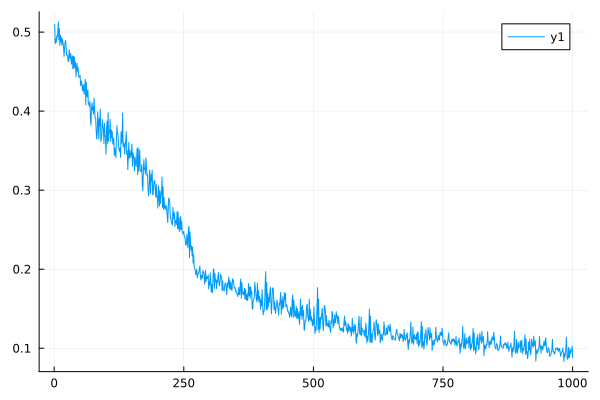

In [30]:
plot(losses)

In [31]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.09520603500490019, 0.983203125)

In [32]:
yt, _ = model(x, ps_train, st_train)

([0.03426326178407966 0.1884311952161211 … 0.3946288523610748 0.3778568906754587; 0.3332872486029667 0.2951151460542419 … 0.236094035321631 0.06527700821995068], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [33]:
ps_train

(layer_1 = (bias = Float32[0.2118337; 0.25200406;;], scale = Float32[0.79320455; 0.8671251;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.10259967 -0.056138404; 0.030605055 0.034390744; … ; 0.112613924 0.12548086; -0.013373454 0.13393202], bias_real = Float32[0.97534525, 0.98212874, 0.8002509, 1.0033823, 1.0261248, 0.92010224, 0.9399406, 1.0279227, 0.87734455, 0.99687  …  0.84923756, 0.86697584, 0.94516754, 0.98093194, 0.975632, 0.93395567, 0.98050535, 0.96922135, 0.90256816, 0.9452845], bias_imag = Float32[-0.022570381, -5.091935f-5, 0.12201409, -0.023621213, 0.039225977, 0.0797794, 0.016829196, -0.019530589, 0.069200985, 0.0011742254  …  0.10386268, 0.11213426, 0.02493377, -0.01695978, 0.04430926, -0.068033986, 0.00048863713, -0.010605197, -0.05614363, 0.032848332]), layer_5 = (weight = Float32[-0.8124655 0.22268978 … 0.039550584 0.30010292; 0.035162233 -0.32679126 … -0.41760495 0.9701676], bias_real = Float32[0.9554462, 0.8507874], bias_imag = Fl

In [34]:
yt_spk, _ = spk_model(x, ps_train, st_train)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [35]:
pt = train_to_phase(yt_spk.train, spk_args=spk_args);

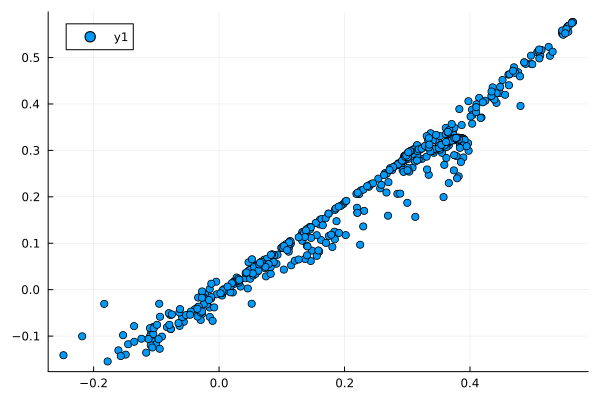

In [36]:
scatter(vec(yt), vec(pt[5,:,:]))

In [37]:
cycle_correlation(yt, pt)

10-element Vector{Float64}:
 -0.1231261389546749
  0.9096247332113169
  0.9588069734408169
  0.9766241062180915
  0.9849805974750797
  0.9894701523321673
  0.9920800373815196
  0.9936756510055252
  0.994685795481569
  0.4678526313056341

In [14]:
model, ps, st = build_mlp(args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.09775257 -0.033171576; 0.020251632 0.0070170956; … ; 0.04797584 0.04434996; -0.002902955 0.14405486], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_5 = (weight = Float32[-0.7682285 0.26694193 … 0.07480648 0.34993985; 0.15990366 -0.17788795 … -0.27716428 1.1225573], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [15]:
spk_model, _, _ = build_spiking_mlp(args, spk_args)

(Chain(), (layer_1 = (bias = Float32[0.0; 0.0;;], scale = Float32[1.0; 1.0;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.09775257 -0.033171576; 0.020251632 0.0070170956; … ; 0.04797584 0.04434996; -0.002902955 0.14405486], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_5 = (weight = Float32[-0.7682285 0.26694193 … 0.07480648 0.34993985; 0.15990366 -0.17788795 … -0.27716428 1.1225573], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im])), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [16]:
y, _ = model(x, ps, st)

([-0.0019279659805481156 -0.03240955426094522 … -0.04047798561910448 -0.022848835911276753; -0.00396018678206813 0.011284628756278715 … -0.0020098326228306664 0.0010613369167577354], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [17]:
y_spk, _ = spk_model(x, ps, st)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [18]:
y_spk.train.offset

0.5

In [19]:
p_spk = train_to_phase(y_spk);

In [20]:
size(p_spk)

(10, 2, 256)

In [21]:
size(y)

(2, 256)

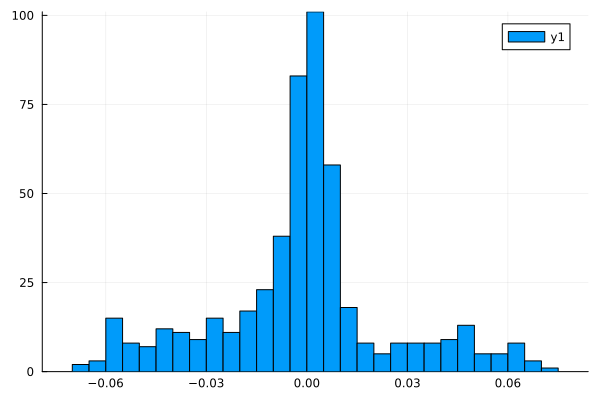

In [22]:
histogram(vec(p_spk[5,:,:]))

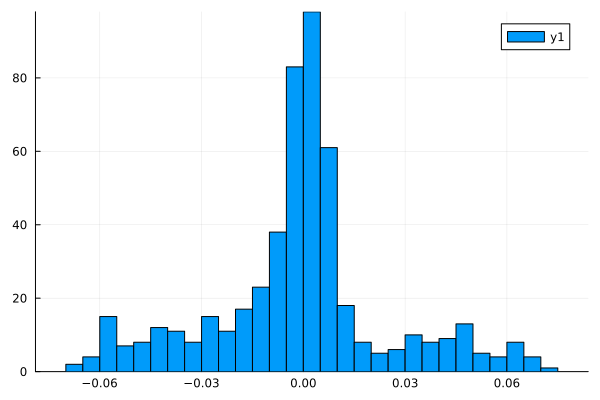

In [23]:
histogram(vec(p_spk[6,:,:]))

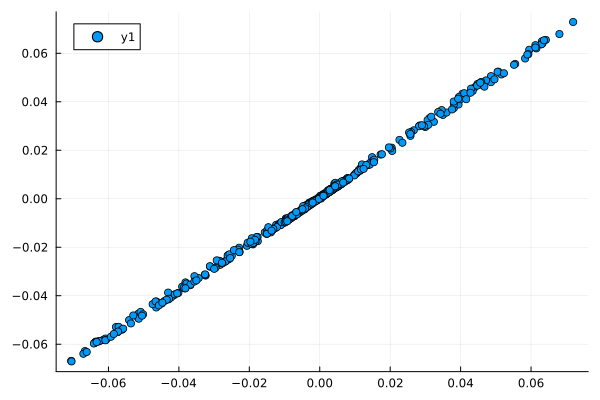

In [24]:
scatter(vec(y), vec(p_spk[5,:,:]))

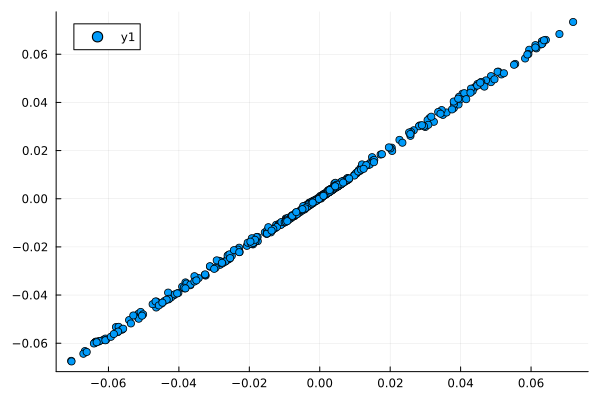

In [25]:
scatter(vec(y), vec(p_spk[6,:,:]))

In [26]:
y |> size

(2, 256)

In [27]:
p_spk |> size

(10, 2, 256)

In [28]:
cycle_correlation(y, p_spk)

10-element Vector{Float64}:
 NaN
   0.9993114918297449
   0.9993717809280009
   0.9993813874975087
   0.9993840329254258
   0.9993848942590626
   0.9993851570696396
   0.999385188220038
   0.9993851272233564
   0.9803989790111869

In [29]:
losses, ps_train, st_train = train(model, ps, st, train_loader, args)

[ Info: Training on CPU


(Any[0.5098835524761419, 0.48531777593645103, 0.49141366870697245, 0.4869352198115586, 0.4954341180146203, 0.49331390013835236, 0.500454739484879, 0.5127269640456782, 0.4901614787989495, 0.50440080558945  …  0.10231613969226308, 0.11466853096891988, 0.09981688998099185, 0.10328609014078254, 0.11305977410302301, 0.10541545822809553, 0.10953221029307796, 0.10779667537709267, 0.11196697251769608, 0.10054320846787895], (layer_1 = (bias = Float32[0.23440075; 0.26354653;;], scale = Float32[0.76589984; 0.8408349;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.10640858 -0.058780227; 0.027585264 0.033256028; … ; 0.10579818 0.12190131; -0.013320172 0.1329216], bias = ComplexF32[0.99907935f0 - 0.024899913f0im, 0.9998315f0 - 0.003999493f0im, 0.9835699f0 + 0.11965993f0im, 1.0013618f0 - 0.023742434f0im, 1.0016277f0 + 0.043334436f0im, 0.9892985f0 + 0.086249486f0im, 0.99898756f0 + 0.020515252f0im, 1.0019902f0 - 0.022909062f0im, 0.99511945f0 + 0.06976576f0im, 1.00013

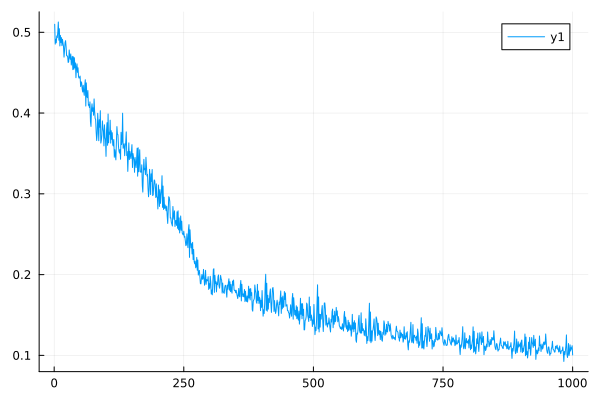

In [30]:
plot(losses)

In [31]:
loss_and_accuracy(test_loader, model, ps_train, st_train)

(0.10753648793823992, 0.980859375)

In [32]:
yt, _ = model(x, ps_train, st_train)

([0.010496643615467779 0.2256036370294392 … 0.3682556459562365 0.36249741842666333; 0.32391695128787684 0.29890415657618524 … 0.24608717796423646 0.06777562824054449], (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [33]:
ps_train

(layer_1 = (bias = Float32[0.23440075; 0.26354653;;], scale = Float32[0.76589984; 0.8408349;;]), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = (weight = Float32[-0.10640858 -0.058780227; 0.027585264 0.033256028; … ; 0.10579818 0.12190131; -0.013320172 0.1329216], bias = ComplexF32[0.99907935f0 - 0.024899913f0im, 0.9998315f0 - 0.003999493f0im, 0.9835699f0 + 0.11965993f0im, 1.0013618f0 - 0.023742434f0im, 1.0016277f0 + 0.043334436f0im, 0.9892985f0 + 0.086249486f0im, 0.99898756f0 + 0.020515252f0im, 1.0019902f0 - 0.022909062f0im, 0.99511945f0 + 0.06976576f0im, 1.0001307f0 + 0.0025999243f0im  …  0.991538f0 + 0.10262958f0im, 0.98549557f0 + 0.102277406f0im, 0.99982274f0 + 0.02553155f0im, 0.9999535f0 - 0.018835627f0im, 0.9987154f0 + 0.04646128f0im, 0.99856615f0 - 0.08486279f0im, 0.9996471f0 + 0.0009740613f0im, 0.9993876f0 - 0.011075502f0im, 0.99586916f0 - 0.071216196f0im, 0.9990014f0 + 0.033265274f0im]), layer_5 = (weight = Float32[-0.8120718 0.22282161 … 0.038903046 0.30000314; 0.0

In [34]:
yt_spk, _ = spk_model(x, ps_train, st_train)

(SpikingCall(Spike Train: (2, 256) with 5120 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0)), (layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [35]:
pt = train_to_phase(yt_spk.train, spk_args=spk_args);

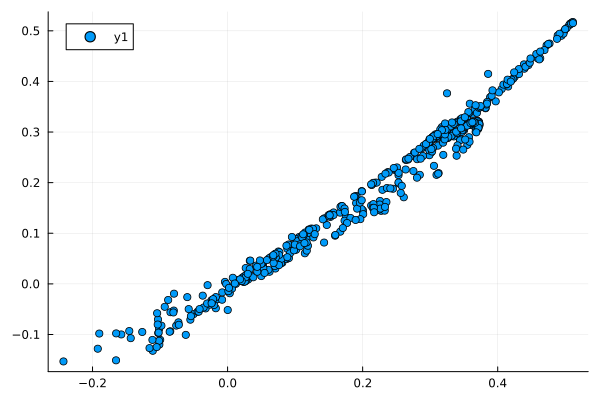

In [36]:
scatter(vec(yt), vec(pt[5,:,:]))

In [37]:
cycle_correlation(yt, pt)

10-element Vector{Float64}:
 -0.12245489967831188
  0.9275655245963351
  0.9683917982128859
  0.9827321842190845
  0.9892250456365613
  0.9925707533002173
  0.9944325556875974
  0.9955226028458065
  0.996184269715372
  0.5938621053177805

In [40]:
import .PhasorNetworks: PhasorDenseF32